In [3]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import time
import collections
import community
import scipy.io
from networkx.algorithms.link_analysis import hits
from itertools import product
import itertools
#import bct 

#1.Creation of Graph
def createGraph(file):
    G=nx.Graph()

    mat = scipy.io.loadmat(file) #matlab file containing an adjacency matrix for the coactivation 
    #network that includes the weights of each edge and the coordinates of each node in the brain

    content = list(mat.values()) #content[3] weights of the edges; content[4] coordinates
    #print(content[3])
    G = nx.from_numpy_matrix(content[3])
    #values={edge: G[edge[0]][edge[1]]['weight']  for edge in G.edges}
    #print(values)
    #print(G[0][1]['weight'])
    #nx.set_edge_attributes(G, {e:G[e[0]][e[1]]['weight'] for e in G.edges}, 'weight')
    
    #in_degree = dict(nx.degree(G))
    #print(in_degree)
    #nodes = list(G)
    #for i, j in product(range(len(nodes)),range(len(nodes))):
    #M = np.sum([A[i,j]] for i, j in product(range(len(nodes)),range(len(nodes))) ])
   # print("M:", M)
    return G

#Degree analysis

#Average Degree
def averageDegree(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    av_degree = (2*E)/N
    return av_degree

#Average Weighted Degree:
def averageWeightedDegree(G):
    N = G.number_of_nodes()
    weightedDegree = np.zeros(N)
    #we start by computing the weighted degree for each node (sum of weights of the edges linked to that node        
    for u, v, w in G.edges(data = 'weight'):
        #add weight to both nodes that share the edge
        weightedDegree[u] += w
        weightedDegree[v] += w
    print("weigtedDegree:",weightedDegree)
    #print("Sum of weightedDegree:", sum(weightedDegree))
    av_weightedDegree = sum(weightedDegree)/N
    return av_weightedDegree

#Degree Distribution
def degreeDistribution(G):
    #get sequence of the degrees of each node ordered 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    #print("Degree sequence", degree_sequence)
    degreeCount = collections.Counter(degree_sequence) #gives a list that has the degree and number of times it repeats
    #print("Degree count", degreeCount)
    degree, count = zip(*degreeCount.items()) #to obtain arguments separated 
    #print(degree)
    
    plt.figure() 
    plt.bar(degree, count, width=1) #plot histogram
    plt.xticks(np.arange(0, 190, 10))
    plt.title("Degree Histrogram")
    plt.ylabel("number of nodes")
    plt.xlabel("k")

#put histogram in range 10 by 10 - equal to the one in the article    

#determine hubs in network to verify its location in the brain
def hubsComputation(G):
    #with hits algorithm we can determine two values for each node: hubs and authorities. Hubs estimates the node 
    #value based on outgoing links and authorities estimates the node value based on the incoming links
    
    #we can determine each node's hub value, that estimates the value of its links to other pages, to select the most
    #important nodes
    
    #http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html
    
    hubs, authorities = hits(G)
    #print("Hubs values:", hubs.items())
    #print("Authorities values:", authorities)
    #these values will be approximately equivalent since we have an undirected graph
    
    hubs_sequence = sorted(hubs.items(),key=itemgetter(1),reverse=True)
    #print("Hubs sequence:", hubs_sequence)
    
    top_ten_hubs_hits = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        for j in range(len(hubs_sequence)):      
            if hubs_sequence[j][1] > max: 
                pair = hubs_sequence[j]
                max = hubs_sequence[j][1];
                node = hubs_sequence[j][0]
        
        hubs_sequence.remove(pair);
        top_ten_hubs_hits.append(node) 
          
    print("Top ten nodes, considering hub value:", top_ten_hubs_hits) 
    
    #we can also select the nodes with highest degree since they will be hubs (a lot of links to other links)
    
    degrees = G.degree() #get list with pairs (node, degree)
    #print("Degrees:", degrees)
    degree_sequence = sorted(G.degree(),key=itemgetter(1),reverse=True) #get list with pairs (node, degree) sorted
    #by degree
    #print("Degree sequence:", degree_sequence)
    
    top_ten_hubs_degree = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        pair = ()
        for j in range(len(degree_sequence)):      
            if degree_sequence[j][1] > max: 
                pair = degree_sequence[j]
                max = degree_sequence[j][1];
                node = degree_sequence[j][0]
        #print("max:", max)
        #print("node:", node)
        degree_sequence.remove(pair);
        top_ten_hubs_degree.append(node) 
          
    print("Top ten hubs, considering degree:", top_ten_hubs_degree)

G = createGraph('Coactivation_matrix.mat')

av_degree = averageDegree(G)
print("The Average Degree of the network is: ", av_degree)

av_w_degree = averageWeightedDegree(G)
print("The Average Weighted Degree of the network is: ", av_w_degree)

degreeDistribution(G)

hubsComputation(G)

#using R function mni_to_region_name(x,y,z) we can obtain the region where these coordinates are located 
#when the mni coordinate do NOT have a corresponding region -> output closest region and distance to it

#considering the ten hubs, in terms of hits algorithm, we have that:

# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 492 - (7.942446043165461, 14.050359712230204, 49.992805755395680) - "Supp_Motor_Area_R"
# 39 - (-51.270886075949360, 12.126582278481010, 24.997468354430380) - "Frontal_Inf_Oper_L"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"

#considering the ten hubs, in terms of degree, we have that: (8 of the hubs are the same)

# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 495 - (6.018018018018012, 9.360360360360374, 59.297297297297290) - "Supp_Motor_Area_R"
# 351 - (-24.787003610108300, -64.057761732851990, 56.772563176895320) - "Parietal_Sup_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"


print("Finish")

The Average Degree of the network is:  58.38557993730407
weigtedDegree: [ 1.84655266  1.49538297  2.18348341  1.95244528  1.47978103  2.98989526
  4.90682517  7.02371493  1.46129755  2.97726341  2.56848866  2.89338554
  2.27222163  2.06288485  2.29949188  1.81949449  7.10833216  2.26435859
  4.37022713  6.69638231  3.93793323  1.90862804  3.33631525  2.40235497
  1.53665523  2.7282733   1.241074    2.17748076  1.60964632  2.29623718
  1.67360841  2.21418799  1.79740468  2.08387687  1.81133242  3.35735761
  2.61762057  5.98086586  9.63757731  3.78481289  4.39079507  6.55055805
  6.78857206  6.3884009   7.09987759  4.53891056  4.73927572  2.08075329
  2.70920917  1.82914875  4.40773764  2.59907229  1.34047289  1.69071392
  2.72009768  1.39244172  1.35186739  3.35518795  0.83280938  1.64587327
  2.1415914   1.24291565  5.75699168  4.02973084  3.1847943   5.14842509
  2.36281894  2.54648031  4.57766723  5.70686941  6.93674412  2.32154083
  1.95193265  5.92341119  1.77881412  2.95501045  4.

In [19]:
#3.Study of Communities in the Coactivation network

from modularity_maximization import partition
from modularity_maximization.utils import get_modularity

# Modularity is one measure of the structure of networks or graphs. It was designed to measure the strength of 
#division of a network into modules (also called groups, clusters or communities). 
#Networks with high modularity have dense connections between the nodes within modules but sparse connections 
#between nodes in different modules.

def communities(G):
    #first compute the best partition
    part = community.best_partition(G) #returns dictionary assign a community (integer) to each node
    mod = community.modularity(part, G) #compute modularity
    print("Modularity of the network:", mod)
    
    # Plot, color nodes using community structure
    values = [part.get(node) for node in G.nodes()] #creates a list with the community number for each node in the 
    #order that appears in G.nodes()
        
    # it will use those community numbers to determine the color of the nodes. 
    #All nodes which have been assigned to the same community will be given the same color.
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False, dpi=1200)
    plt.figure(figsize=(100, 100))
    plt.show()
    
    #determine number of nodes in each community
    number_communities = max(values)+1
    print("Number of communities:", number_communities)
    count_communities = np.zeros((number_communities,), dtype=int)
    content_communities = []
    for n in range(number_communities):
        content_communities.append([])
    for key,value in part.items():
       # print("Key:", key) #node
       # print("value:", value) #community
        count_communities[value] += 1
        content_communities[value].append(key)
    
    print(count_communities)
    return [part, content_communities] 


#Não alterei nada do código ainda!

def newman_communities(G):
    
    comm_dict = partition(G)
    communities_newman = []
    for comm in set(comm_dict.values()):
        communities_newman.append([])
        print("Community %d"%comm)
        #values = ','.join(str(v) for v in value_list)
        print(', '.join([str(node) for node in comm_dict if comm_dict[node] == comm]))
        for node in comm_dict:
            if (comm_dict[node] == comm):
                communities_newman[node].append(comm)
        
    print('Modularity of such partition for the graph is %.3f' % get_modularity(G, comm_dict))
    return communities_newman


In [21]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import pandas as pd

robjects.r['load']("metadata.RData")
matrix=robjects.r['Result']

def comun_dist(communities):
    
    for i in range(len(communities)):
        sub_metadata=[]
        for node in communities[i]:
            sub_metadata.append(list(matrix[node]))
            
        df = pd.DataFrame(sub_metadata)

        dist=df[0].value_counts() 

        dist.plot(kind='bar')
        title="Community {}".format(i)
        plt.title(title)
        plt.show()


ModuleNotFoundError: No module named 'rpy2'

Modularity of the network: 0.467445852922999


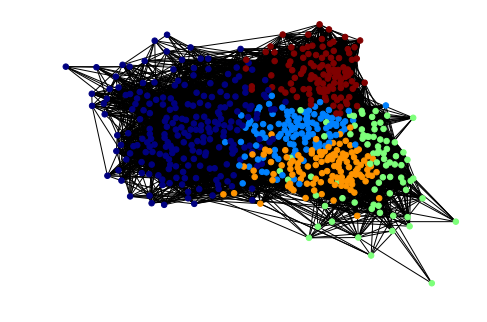

Number of communities: 5
[219 113  78 116 112]
[[0, 1, 4, 8, 9, 11, 13, 14, 21, 22, 23, 24, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 61, 81, 82, 83, 84, 85, 86, 90, 92, 99, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 132, 134, 136, 137, 138, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 187, 188, 189, 190, 191, 196, 198, 199, 200, 201, 205, 207, 209, 210, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 276, 287, 294, 295, 297, 299, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 427, 428, 431, 432, 438, 442, 443, 445, 446, 448, 449, 451, 466, 467, 468, 469, 470, 471, 499, 508, 512, 514, 515, 516, 517, 518, 519, 520, 522, 523, 524, 529, 530, 531, 533, 534, 535, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574,

NameError: name 'comun_dist' is not defined

In [18]:
partitions, communities= communities(G)

print(communities)

comun_dist(communities)

In [15]:
communities_newman = newman_communities(G)

print(communities_newman)

comun_dist(communities_newman)

KeyboardInterrupt: 

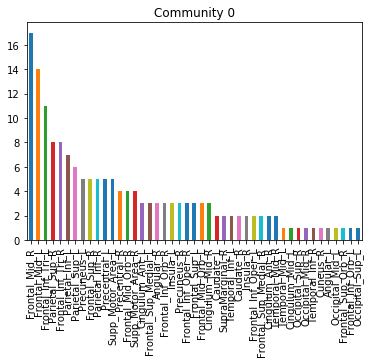

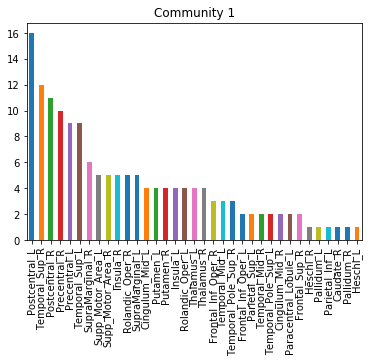

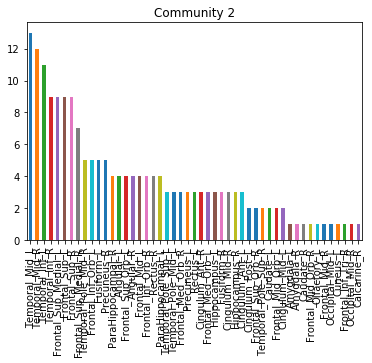

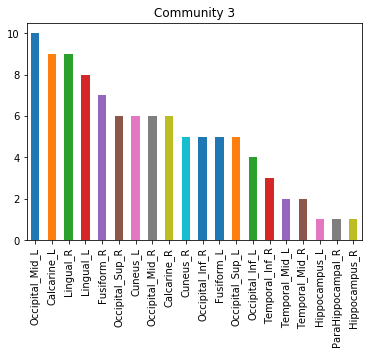

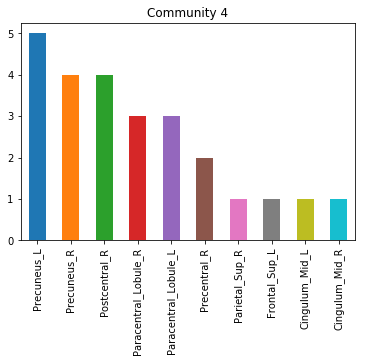

In [53]:
import igraph as ig
from igraph import *

Gi= ig.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist())

communities2=Gi.community_infomap()

comun_dist(communities2)

In [41]:
#Replace labels of matrix with numbers !!!! fazer NMI para os resultados das diferentes comunidades obtidas pelos algoritmos
matrix_list=[]
for i in range(638):
    matrix_list.append(list(matrix[i]))

matrix_df = pd.DataFrame(list(matrix_list))

print(matrix_df[0])
real_communities=pd.Categorical(matrix_df[0], categories=matrix_df[0].unique()).codes

print(real_communities)

0       Cingulum_Ant_R
1       Cingulum_Ant_R
2       Cingulum_Ant_R
3       Cingulum_Ant_R
4       Cingulum_Ant_R
5       Cingulum_Mid_L
6       Cingulum_Mid_L
7       Cingulum_Mid_L
8       Cingulum_Mid_L
9       Cingulum_Mid_L
10      Cingulum_Mid_L
11      Cingulum_Mid_L
12      Cingulum_Mid_L
13      Cingulum_Mid_R
14      Cingulum_Mid_R
15      Cingulum_Mid_R
16      Cingulum_Mid_R
17      Cingulum_Mid_R
18      Cingulum_Mid_R
19      Cingulum_Mid_R
20      Cingulum_Mid_R
21      Cingulum_Mid_R
22     Cingulum_Post_L
23     Cingulum_Post_L
24         Precuneus_R
25            Cuneus_L
26            Cuneus_L
27            Cuneus_L
28            Cuneus_L
29            Cuneus_L
            ...       
608     Temporal_Sup_R
609     Temporal_Sup_R
610     Temporal_Sup_R
611     Temporal_Sup_R
612     Temporal_Sup_R
613     Temporal_Sup_R
614     Temporal_Sup_R
615     Temporal_Sup_R
616     Temporal_Sup_R
617     Temporal_Sup_R
618     Temporal_Sup_R
619     Temporal_Sup_R
620        

In [56]:
NMI = compare_communities(partitions.values(), real_communities, method="nmi")

print(NMI)

0.3624167800971483


In [55]:
NMI2= compare_communities(communities2.membership, real_communities, method="nmi")

print(NMI2)

0.3351165503419542


In [ ]:
#implement 2 communities algorithms from sugestions in project doc
#   Affinity-Graph-Model for discovering overlapping communities.


#  clique percolation method for uncovering the overlapping community structure of complex network.

#see finder -> enumeração de cliques -> intersecção -> comunidades
#llp

#(capitulo 10 mining ? datasets)

